### A quick demonstration of C-inverse filtering to kappa maps

In [1]:
import numpy as np
import healpy as hp
from matplotlib.pyplot import *
import scipy
import ipywidgets as widgets
import pickle
# from cmblensplus/wrap/
import basic
import curvedsky as cs
# from cmblensplus/utils/
import plottools as pl
import maptools
# others
import local
import tools_multitracer as mass
import warnings
warnings.filterwarnings("ignore")

In [2]:
# define parameters
nside = 512        # CMB map resolution
lmax  = 2*nside     # maximum multipole of alm to be generated
npix = hp.nside2npix(nside)
L = np.linspace(0,lmax,lmax+1)
zbn = {'euc':5,'lss':5}

In [3]:
glob = local.analysis()

In [4]:
klist = mass.tracer_list(add_euc=zbn['euc'], add_lss=zbn['lss'])

In [5]:
frac = mass.galaxy_distribution(np.linspace(0,50,1000),zbn=zbn)[3]

### Read galaxy survey mask

In [6]:
surveys = ['litebird','euclid','lsst','cib','cmbs4']
params = local.analysis()

In [7]:
W = {}
W['litebird'] = hp.read_map(params.wind['litebird'])
for survey in surveys:
    if survey == 'litebird': continue
    W[survey] = W['litebird']*hp.read_map(params.wind[survey])

In [8]:
fsky = np.average(W['litebird'])

### Prepare signal map

In [9]:
# load cl of mass tracers
Cov = mass.get_covariance_signal(lmax,add_euc=zbn['euc'],add_lss=zbn['lss'])

In [10]:
kalm = glob.load_input_kappa(1,lmax)

In [11]:
glm = cs.utils.gaussalm(Cov[1:,1:,:],ilm=kalm)
print(np.shape(glm))

(12, 1025, 1025)


In [12]:
# Gaussian signal alms are generated here
alm = {}
for I, m in klist.items():
    if m in ['klb','ks4']: 
        alm[m] = glm[0]
    else:
        alm[m] = glm[I-1]

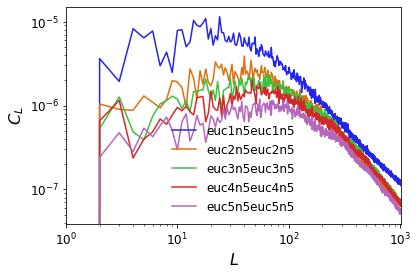

<Figure size 432x288 with 0 Axes>

In [13]:
pl.plot_1dstyle(xlog=True,ylog=True,xmin=1,xmax=lmax)
for I, m0 in klist.items():
    for J, m1 in klist.items():
        if I>J: continue
        if not ( 'euc' in m0 and 'euc' in m1 and m0==m1 ) : continue
        plot(L,cs.utils.alm2cl(lmax,alm[m0],alm[m1]),label=m0+m1)
legend()
show()
clf()

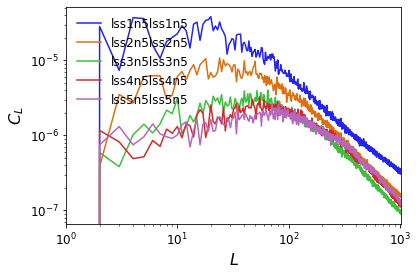

<Figure size 432x288 with 0 Axes>

In [14]:
pl.plot_1dstyle(xlog=True,ylog=True,xmin=1,xmax=lmax)
for I, m0 in klist.items():
    for J, m1 in klist.items():
        if I>J: continue
        if not ( 'lss' in m0 and 'lss' in m1 and m0==m1 ) : continue
        plot(L,cs.utils.alm2cl(lmax,alm[m0],alm[m1]),label=m0+m1)
legend()
show()
clf()

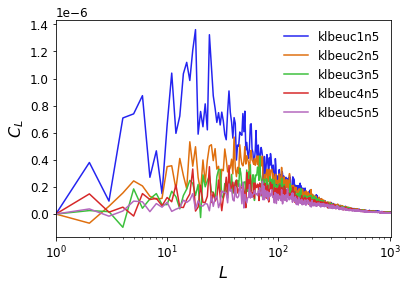

<Figure size 432x288 with 0 Axes>

In [15]:
pl.plot_1dstyle(xlog=True,xmin=1,xmax=lmax)
for I, m0 in klist.items():
    for J, m1 in klist.items():
        if I>J: continue
        if not ( m0=='klb' and 'euc' in m1 ) : continue
        plot(L,cs.utils.alm2cl(lmax,alm[m0],alm[m1]),label=m0+m1)
legend()
show()
clf()

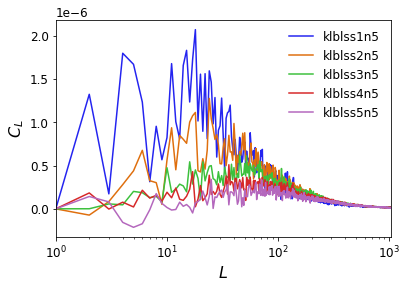

<Figure size 432x288 with 0 Axes>

In [16]:
pl.plot_1dstyle(xlog=True,xmin=1,xmax=lmax)
for I, m0 in klist.items():
    for J, m1 in klist.items():
        if I>J: continue
        if not ( m0=='klb' and 'lss' in m1 ) : continue
        plot(L,cs.utils.alm2cl(lmax,alm[m0],alm[m1]),label=m0+m1)
legend()
show()
clf()

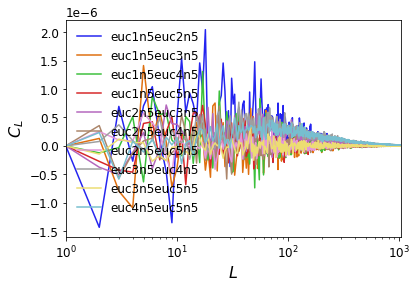

<Figure size 432x288 with 0 Axes>

In [17]:
pl.plot_1dstyle(xlog=True,xmin=1,xmax=lmax)
for I, m0 in klist.items():
    for J, m1 in klist.items():
        if I>J: continue
        if not ( 'euc' in m0 and 'euc' in m1 and m0!=m1 ) : continue
        plot(L,cs.utils.alm2cl(lmax,alm[m0],alm[m1]),label=m0+m1)
legend()
show()
clf()

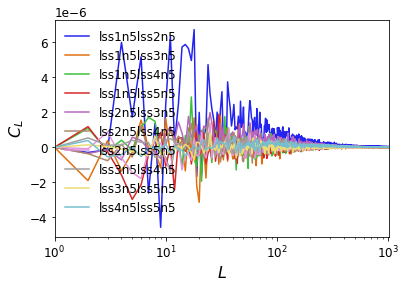

<Figure size 432x288 with 0 Axes>

In [18]:
pl.plot_1dstyle(xlog=True,xmin=1,xmax=lmax)
for I, m0 in klist.items():
    for J, m1 in klist.items():
        if I>J: continue
        if not ( 'lss' in m0 and 'lss' in m1 and m0!=m1 ) : continue
        plot(L,cs.utils.alm2cl(lmax,alm[m0],alm[m1]),label=m0+m1)
legend()
show()
clf()

In [19]:
amap = cs.utils.hp_alm2map(nside,lmax,lmax,alm['klb'])

### Prepare noise map

In [20]:
# prepare reconstruction noise of LB and S4
for experiment in ['litebird','s4']:
    obj = local.forecast(experiment)
    obj.compute_nlkk()

In [21]:
Ncov = mass.get_covariance_noise(lmax,frac=frac,add_euc=zbn['euc'],add_lss=zbn['lss'])

In [22]:
glm = cs.utils.gaussalm(Ncov)
print(np.shape(glm))

(13, 1025, 1025)


In [23]:
# Gaussian signal alms are generated here
nlm = {}
for I, m in klist.items():
    nlm[m] = glm[I]

### Prepare observed map

In [24]:
# observed mass-tracer maps
omap = {}
mask = {}
for I, m in klist.items():
    if m == 'klb':  mask[I] = W['litebird']
    if m == 'ks4':  mask[I] = W['cmbs4']
    if m == 'cib':  mask[I] = W['cib']
    if 'euc' in m:  mask[I] = W['euclid']
    if 'lss' in m:  mask[I] = W['lsst']
    omap[m] = mask[I] * cs.utils.hp_alm2map(nside,lmax,lmax,alm[m]+nlm[m])

In [25]:
#oalm = cs.utils.hp_map2alm(nside,lmax,lmax,omap['I'])
#oalm[:100,:] = 0.
#omap['I'] = mask['cib']*cs.utils.hp_alm2map(nside,lmax,lmax,oalm)

In [26]:
pl.view_maps(omap)

map key list: ['klb', 'ks4', 'cib', 'euc1n5', 'euc2n5', 'euc3n5', 'euc4n5', 'euc5n5', 'lss1n5', 'lss2n5', 'lss3n5', 'lss4n5', 'lss5n5']


### Optimally coadded kappa map

In [27]:
# square root of covariance
nkap = len(klist.keys())

In [28]:
invN = np.reshape(np.array( [ mask[I] for I in range(nkap)]),(nkap,npix))
inls = np.array( [ 1./Ncov[:,:,l].diagonal() for l in range(lmax+1) ] ).T

In [43]:
# cinv options
kwargs_cinv = {
    'chn':  1, \
    'eps':  [1e-4], \
    'itns': [1000], \
    'ro':   10, \
    'stat': 'status.txt' \
}

In [30]:
# kappa maps
kmaps = np.zeros((nkap,npix))
for I, m in klist.items():
    kmaps[I,:] = omap[m]

In [31]:
# inverse noise covariance
#invn = np.reshape(np.array(( W['litebird']/Ncov[0,0,10] , W['cmbs4']/Ncov[1,1,10] )),(2,npix))

In [44]:
# Computing filtered-alms
xlm0 = cs.cninv.cnfilter_kappa(1,nside,lmax,Cov[:1,:1,:],invN[:1,:],kmaps[:1,:],inl=inls[:1,:],**kwargs_cinv)
clm0 = np.array( [ np.dot(Cov[0,:1,l],xlm0[:1,l,:]) for l in range(lmax+1) ] )

In [45]:
xlm1 = cs.cninv.cnfilter_kappa(2,nside,lmax,Cov[:2,:2,:],invN[:2,:],kmaps[:2,:],inl=inls[:2,:],**kwargs_cinv)
clm1 = np.array( [ np.dot(Cov[0,:2,l],xlm1[:2,l,:]) for l in range(lmax+1) ] )

In [34]:
# Computing filtered-alms
xlm2 = cs.cninv.cnfilter_kappa(3,nside,lmax,Cov[:3,:3,:],invN[:3,:],kmaps[:3,:],inl=inls[:3,:],**kwargs_cinv)
clm2 = np.array( [ np.dot(Cov[0,:3,l],xlm2[:3,l,:]) for l in range(lmax+1) ] )

In [35]:
# Computing filtered-alms
xlm3 = cs.cninv.cnfilter_kappa(nkap,nside,lmax,Cov,invN,kmaps,inl=inls,**kwargs_cinv)
clm3 = np.array( [ np.dot(Cov[0,:,l],xlm3[:,l,:]) for l in range(lmax+1) ] )

In [36]:
pickle.dump( (clm0,clm1,clm2,clm3), open(local.data_directory()['mas'] + 'alm/test.pkl',"wb"), protocol=pickle.HIGHEST_PROTOCOL )

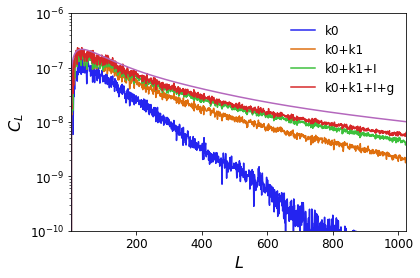

<Figure size 432x288 with 0 Axes>

In [46]:
pl.plot_1dstyle(ylog=True,xmin=2,xmax=lmax,ymin=1e-10,ymax=1e-6)
plot(L,cs.utils.alm2cl(lmax,alm['klb'],clm0)/fsky,label='k0')
plot(L,cs.utils.alm2cl(lmax,alm['klb'],clm1)/fsky,label='k0+k1')
plot(L,cs.utils.alm2cl(lmax,alm['klb'],clm2)/fsky,label='k0+k1+I')
plot(L,cs.utils.alm2cl(lmax,alm['klb'],clm3)/fsky,label='k0+k1+I+g')
plot(L,Cov[0,0,:lmax+1])
legend()
show()
clf()

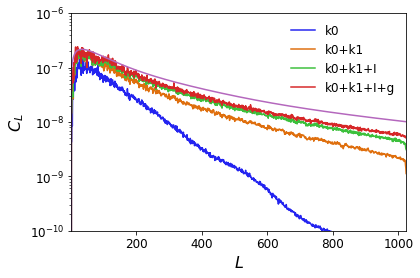

<Figure size 432x288 with 0 Axes>

In [47]:
pl.plot_1dstyle(ylog=True,xmin=2,xmax=lmax,ymin=1e-10,ymax=1e-6)
plot(L,cs.utils.alm2cl(lmax,clm0)/fsky,label='k0')
plot(L,cs.utils.alm2cl(lmax,clm1)/fsky,label='k0+k1')
plot(L,cs.utils.alm2cl(lmax,clm2)/fsky,label='k0+k1+I')
plot(L,cs.utils.alm2cl(lmax,clm3)/fsky,label='k0+k1+I+g')
plot(L,Cov[0,0,:lmax+1])
legend()
show()
clf()

In [39]:
cmap0 = cs.utils.hp_alm2map(nside,lmax,lmax,clm0)
cmap1 = cs.utils.hp_alm2map(nside,lmax,lmax,clm1)
cmap2 = cs.utils.hp_alm2map(nside,lmax,lmax,clm2)
cmap3 = cs.utils.hp_alm2map(nside,lmax,lmax,clm3)

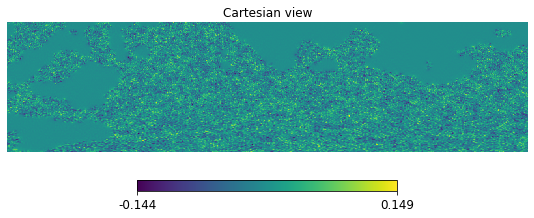

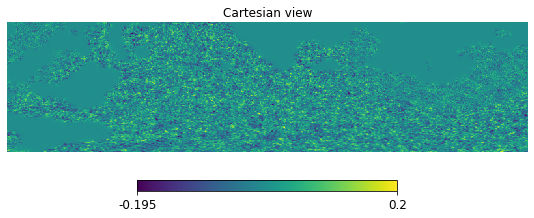

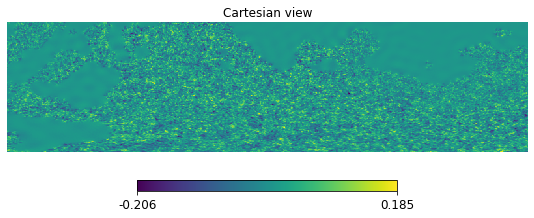

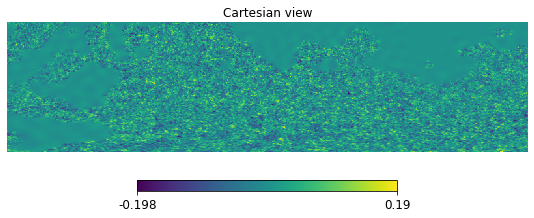

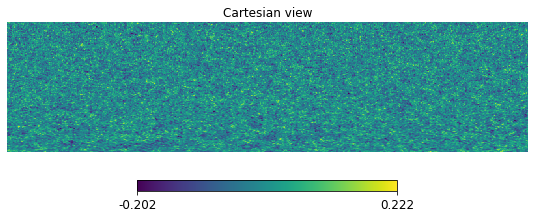

In [40]:
lonra, latra = [-80,80], [-70,-30]
hp.cartview(cmap0,lonra=lonra,latra=latra)
hp.cartview(cmap1,lonra=lonra,latra=latra)
hp.cartview(cmap2,lonra=lonra,latra=latra)
hp.cartview(cmap3,lonra=lonra,latra=latra)
hp.cartview(amap,lonra=lonra,latra=latra)